In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [1]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord, Angle, match_coordinates_3d
import astropy.units as u
from astropy.table import Table
from tqdm.notebook import tqdm

In [2]:
from astropy.io import fits
import astropy.units as u

import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk
import astropy.units as u

import pyia
plt.style.use('seaborn-white')

In [3]:
hdulist = fits.open('TheOGGroup.fits')

In [8]:
df = Table(hdulist[1].data).to_pandas().sort_values('phot_g_mean_mag').reset_index(drop=True)

In [9]:
df[['phot_g_mean_mag', 'source_id']]

,phot_g_mean_mag,source_id
0,7.375855,1189404610382948224
1,7.491980,1549259098113618688
2,7.739772,1610856453920291712
3,8.472794,1523645047031954944
4,8.840790,3958028490314315008
5,8.910282,1490845584382687232
6,9.002782,1523644978312478976
7,9.251204,1236585612107071616
8,9.675173,1476485996883837184
9,10.489188,1501788130259330688


No data found for target "236.1322036518831 11.266318068298254".
No data found for target "236.1322036518831 11.266318068298254".
/Users/ch/K2/repos/lightkurve/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)
/Users/ch/K2/repos/lightkurve/lightkurve/lightcurve.py:702: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning)
/Users/ch/K2/repos/lightkurve/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)
/Users/ch/K2/repos/lightkurve/lightkurve/lightcurve.py:702: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a secon

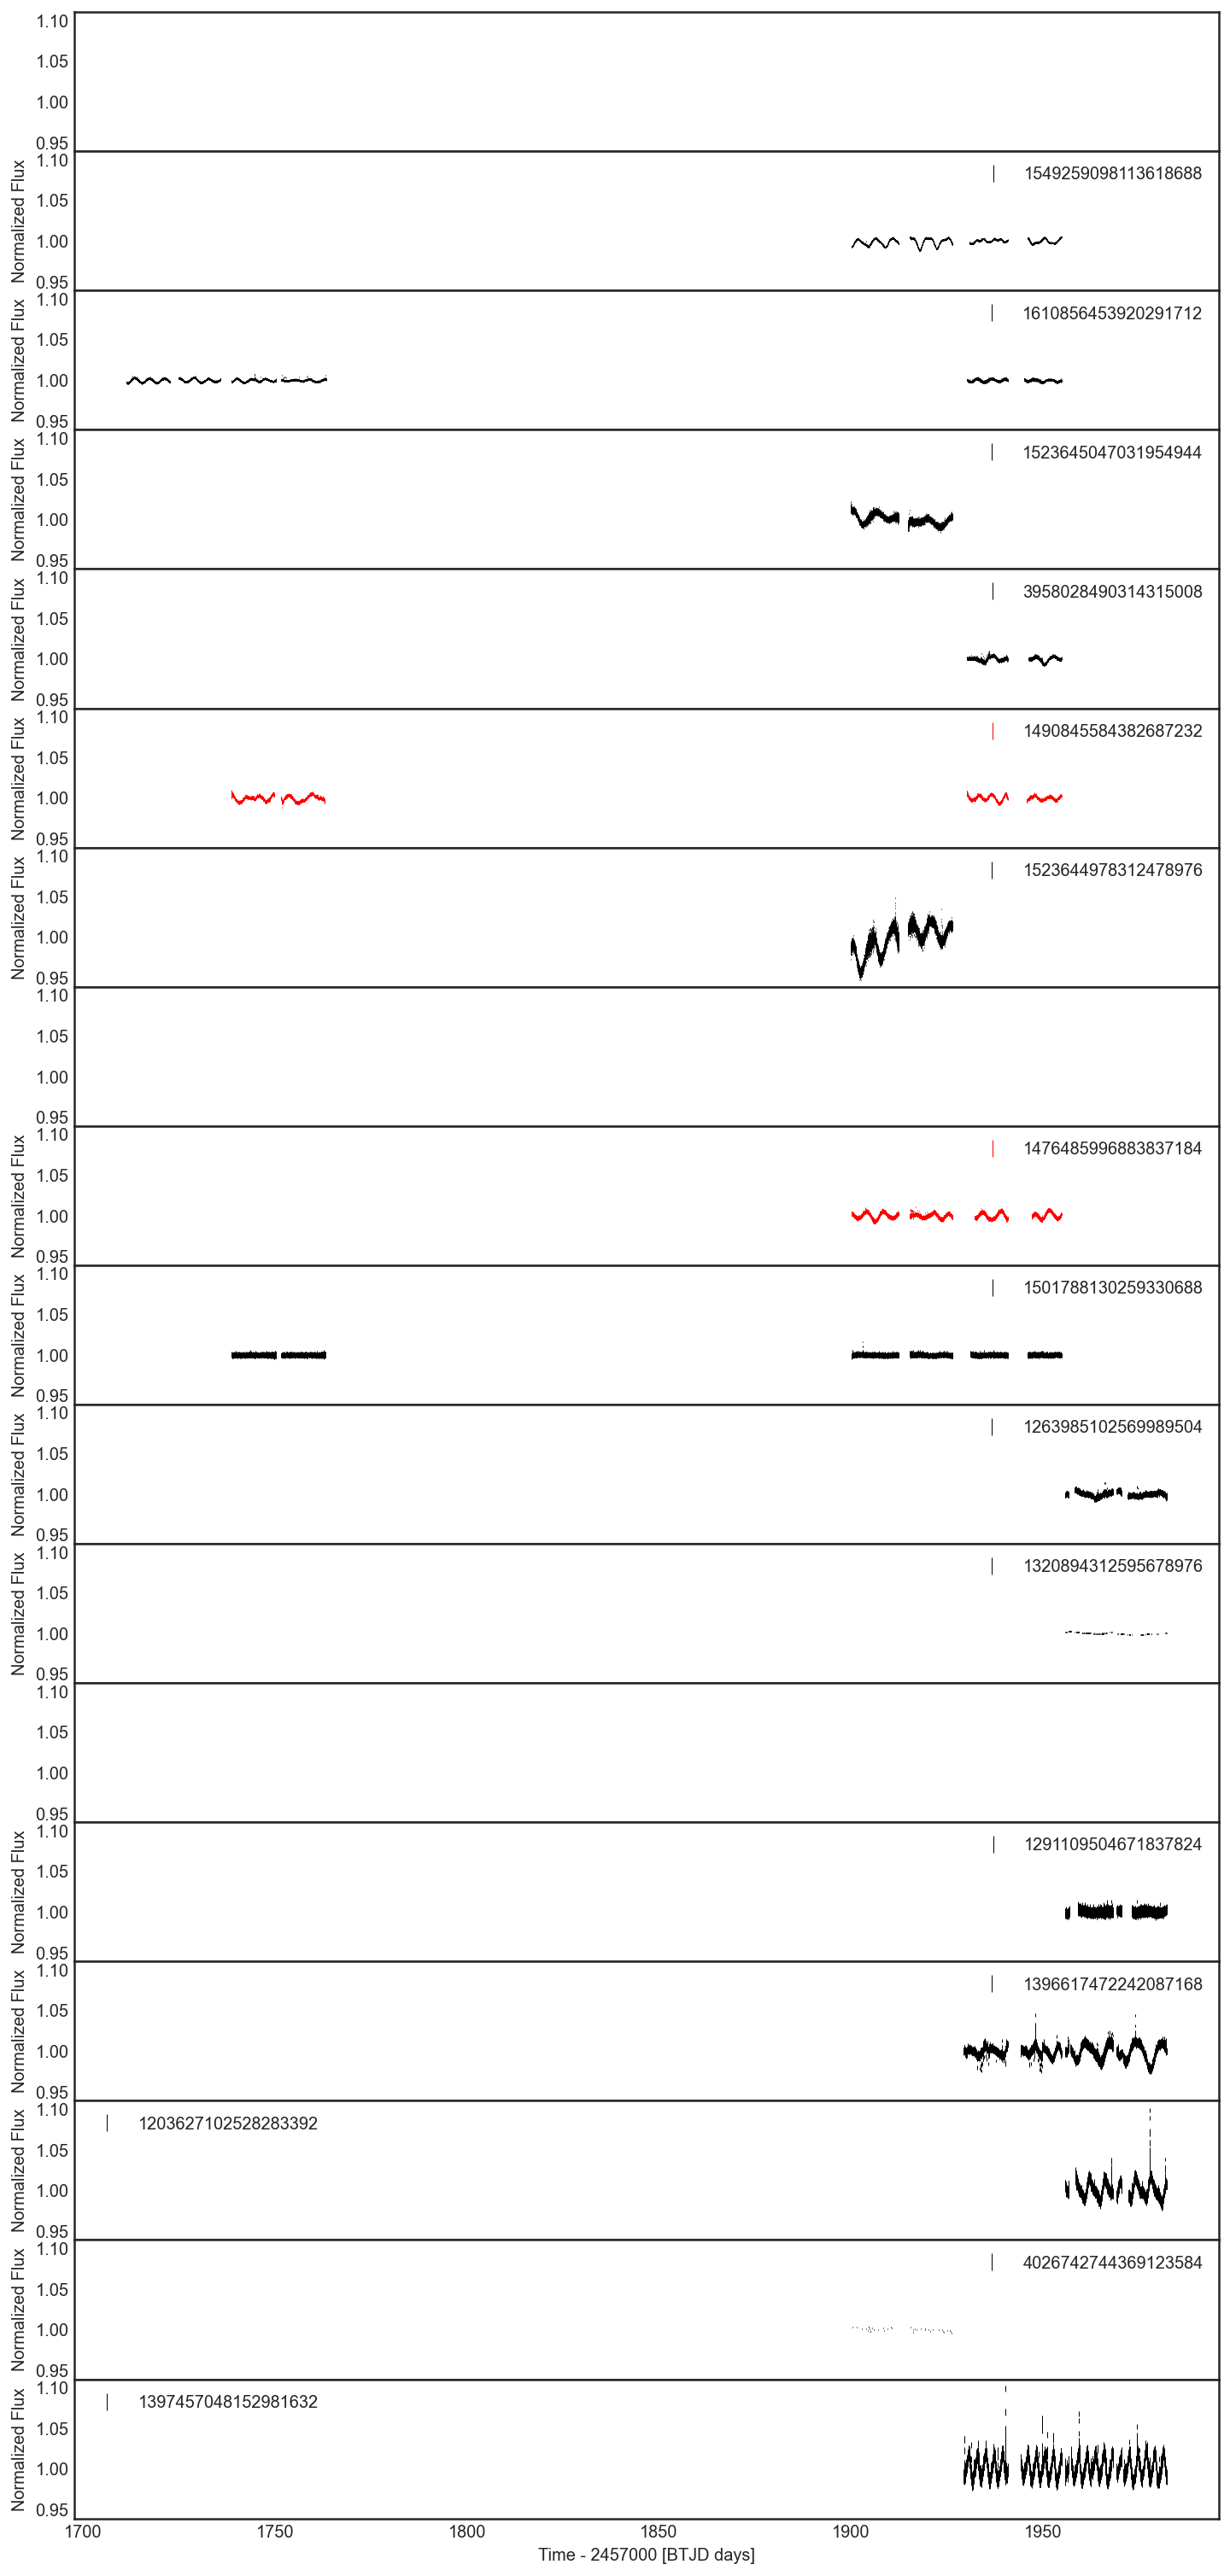

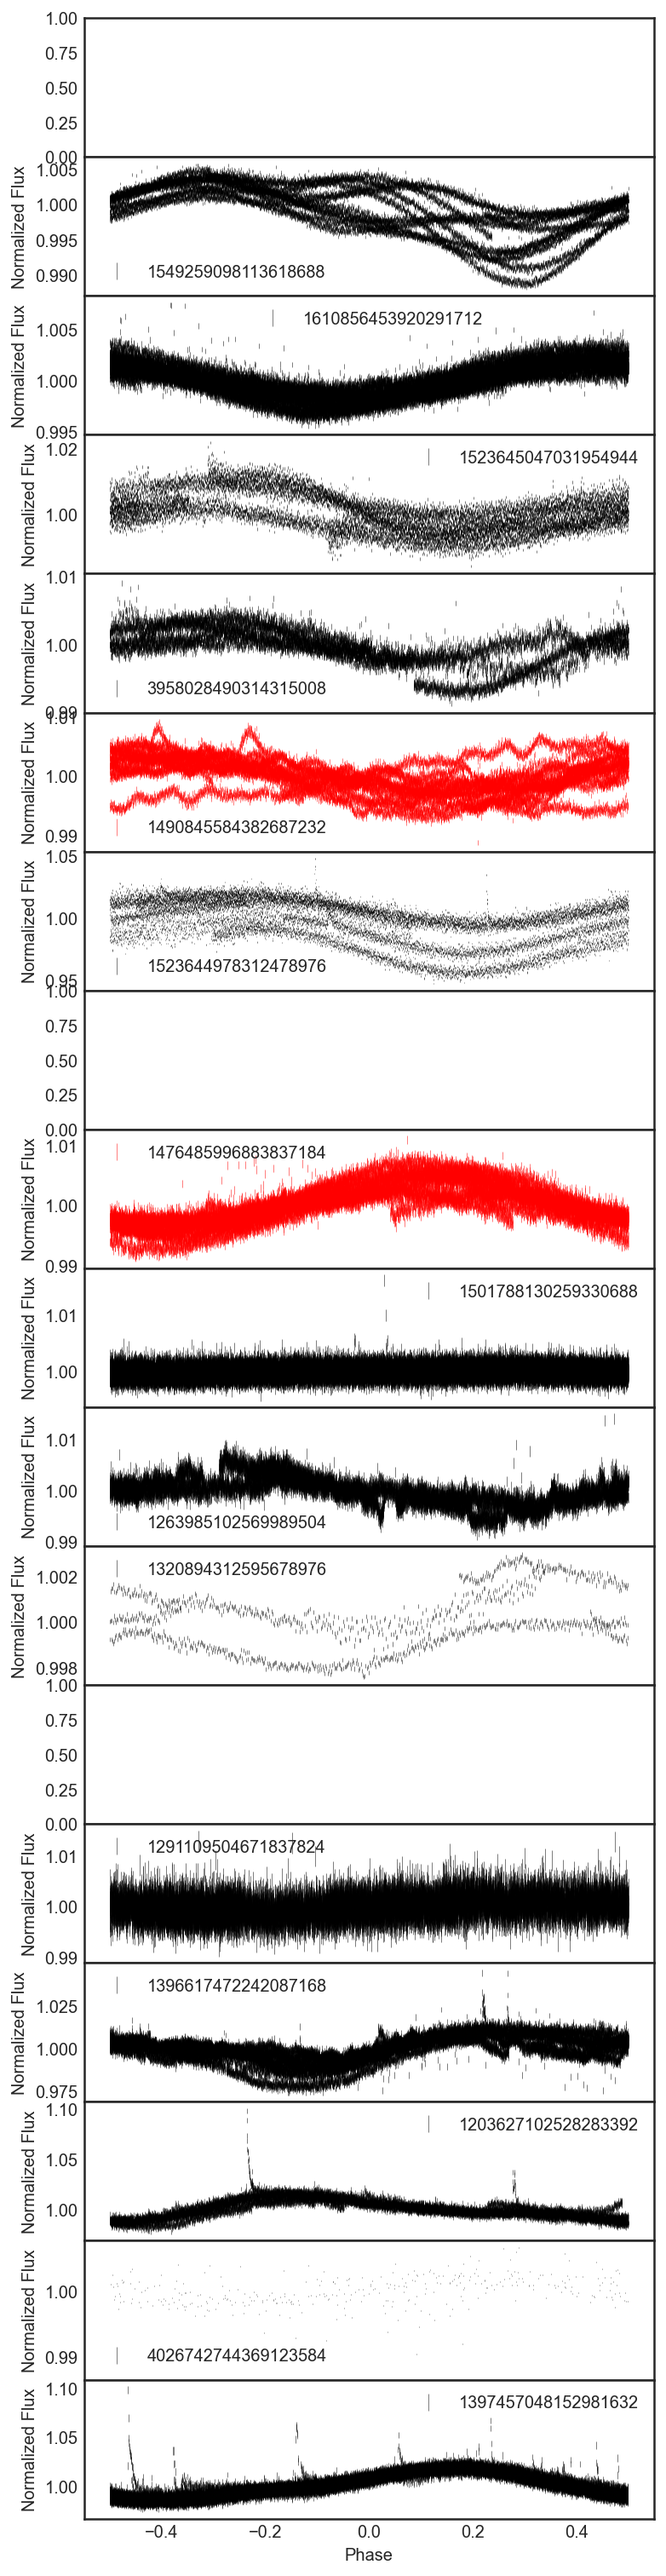

In [79]:

fig, ax = plt.subplots(len(df), figsize=(12, len(df) * 1.5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0)
fig2, ax2 = plt.subplots(len(df), figsize=(6, len(df) * 1.5), sharex=True)
plt.subplots_adjust(hspace=0)

all_lcs = []
for idx, d in df.iterrows():
    ra, dec = d.ra, d.dec
    sr = lk.search_lightcurvefile('{} {}'.format(ra, dec))
    
    if len(sr) == 0:
        sr = lk.search_tesscut('{} {}'.format(ra, dec))
        if len(sr) == 0:
            continue
        tpf = sr.download_all(cutout_size=(10, 11))[0]
        aper = tpf.create_threshold_mask()
        r = lk.correctors.TessPLDCorrector(tpf, aperture_mask=aper)
        lc = r.correct(pixel_components=3, sigma=3).normalize()

        #lc = (lc - r.diagnostic_lightcurves['pix']).normalize()
    else:
        lcs = sr.download_all(quality_bitmask=None)
        lc = lcs.PDCSAP_FLUX.stitch().remove_nans().normalize()#.bin(15, method='mean')
        
    if lc.label in ['TIC 27491137', 'TIC 180695581']:
        c = 'r'
    else:
        c = 'k'
    df.loc[idx, 'TIC_ID'] = lc.label
    lc.label = '{}'.format(int(d.source_id))
    lc.remove_outliers(100).errorbar(ax=ax[idx], c=c, label=lc.label)
    ax[idx].legend()
    per = lc.to_periodogram(minimum_period=0.1, maximum_period=15, oversample_factor=10)
    df.loc[idx, 'period'] = per.period_at_max_power.value
    df.loc[idx, 'amp'] = np.nanpercentile(lc.flux, 90) - np.nanpercentile(lc.flux, 10)

    lc.remove_outliers(100).fold(per.period_at_max_power.value).errorbar(ax=ax2[idx], c=c, label=lc.label, alpha=0.5)
    ax2[idx].legend()
    lc.meta['gaia'] = d
    all_lcs.append(lc)

In [81]:
fig.savefig('lcs.png', dpi=200)

In [82]:
fig2.savefig('lcs_folded.png', dpi=200)

In [97]:
for idx, d in df.iterrows():
    ra, dec = d.ra, d.dec
    result = Vizier.query_region(SkyCoord('{} {}'.format(ra, dec), unit='deg'), radius=Angle(10, "arcsec"), catalog=['J/A+A/588/A103/cat2rxs'])
    if len(result) != 0:
        df.loc[idx, 'xraycounts'] = (result[0]['Cts'].data.data[0])

In [98]:
df.to_csv('preliminary_table.csv', index=False)

In [61]:
og = (df.source_id == 1490845584382687232)
twin = df.source_id == 1476485996883837184

In [29]:
g = pyia.GaiaData(Table.from_pandas(df))

Text(0.5, 1.0, 'Young Moving Group')

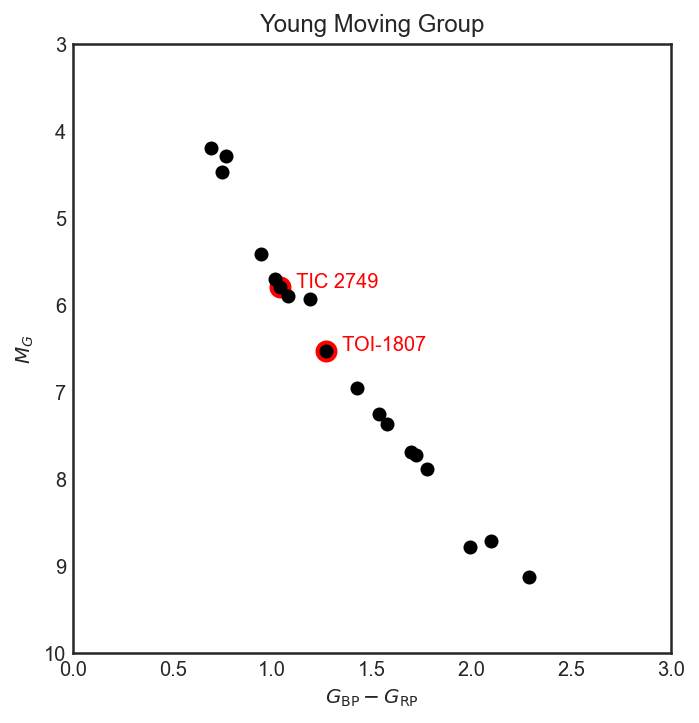

In [85]:
bprp, mg = g.phot_bp_mean_mag - g.phot_rp_mean_mag, g.phot_g_mean_mag - g.distmod

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

#k = ~np.isfinite(df.period)
#im = ax.scatter(bprp[k], mg[k], c='grey', marker='o')

im = ax.scatter(bprp[og], mg[og], c='r', marker='o', s=100, zorder=-10)
im = ax.scatter(bprp[twin], mg[twin], c='r', marker='o', s=100, zorder=-10)

plt.text(bprp[og].value, mg[og].value, '   TIC 2749', c='r')
plt.text(bprp[twin].value, mg[twin].value, '   TOI-1807', c='r')

im = ax.scatter(bprp, mg, c='k')
#cbar = plt.colorbar(im, ax=ax)
#cbar.set_label('Period [d]')

ax.set_xlim(0, 3)
ax.set_ylim(10, 3)

ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')

fig.set_facecolor('w')
fig.tight_layout()
plt.title("Young Moving Group")

Text(0.5, 1.0, 'Young Moving Group')

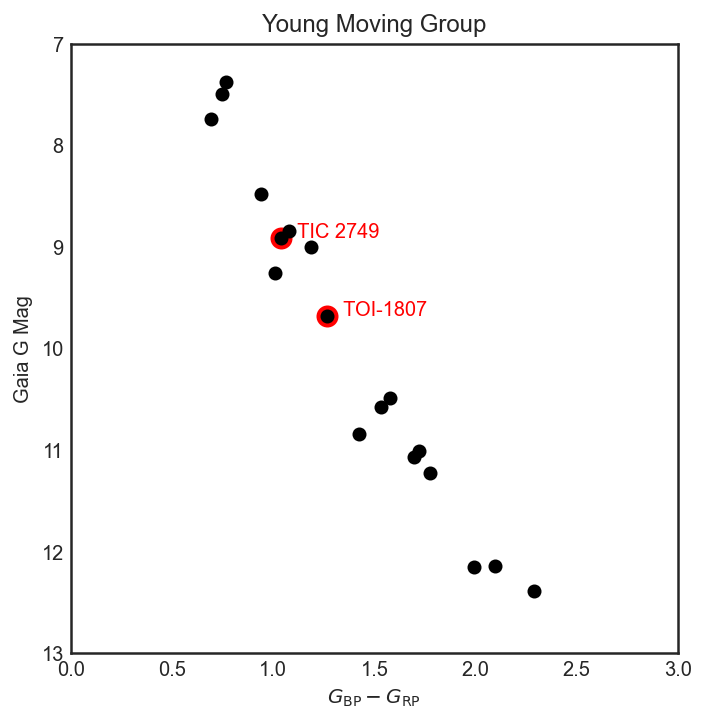

In [107]:
bprp, mg = g.phot_bp_mean_mag - g.phot_rp_mean_mag, g.phot_g_mean_mag #- g.distmod

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

#k = ~np.isfinite(df.period)
#im = ax.scatter(bprp[k], mg[k], c='grey', marker='o')

im = ax.scatter(bprp[og], mg[og], c='r', marker='o', s=100, zorder=-10)
im = ax.scatter(bprp[twin], mg[twin], c='r', marker='o', s=100, zorder=-10)

plt.text(bprp[og].value, mg[og].value, '   TIC 2749', c='r')
plt.text(bprp[twin].value, mg[twin].value, '   TOI-1807', c='r')

im = ax.scatter(bprp, mg, c='k')
#cbar = plt.colorbar(im, ax=ax)
#cbar.set_label('Period [d]')

ax.set_xlim(0, 3)
ax.set_ylim(13, 7)

ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('Gaia G Mag')

fig.set_facecolor('w')
fig.tight_layout()
plt.title("Young Moving Group")

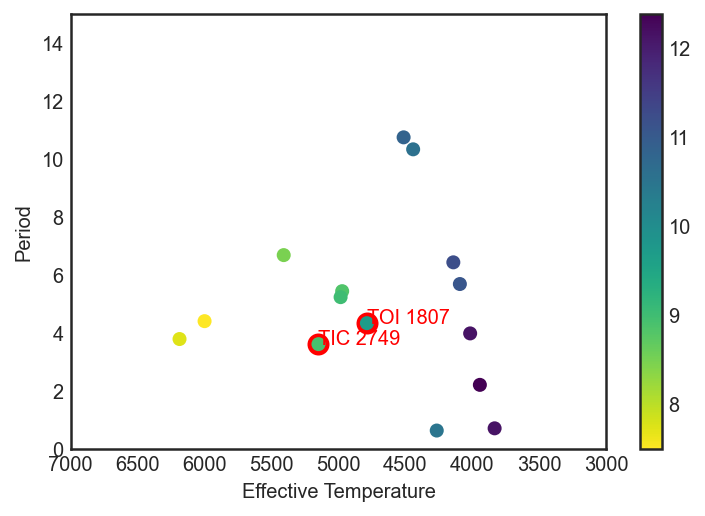

In [96]:
fig = plt.figure()
plt.scatter(df.teff_val, df.period, c=df.phot_g_mean_mag, cmap='viridis_r')
plt.colorbar()
plt.scatter(df.teff_val[og], df.period[og], c='r', s=100, zorder=-1)
plt.scatter(df.teff_val[twin], df.period[twin], c='r', s=100, zorder=-1)

plt.text(df.teff_val[og], df.period[og], 'TIC 2749', color='r')
plt.text(df.teff_val[twin], df.period[twin], 'TOI 1807', color='r')

plt.xlim(7000, 3000)
plt.ylim(0, 15)
plt.xlabel('Effective Temperature')
plt.ylabel('Period')
fig.savefig('color-period.png', dpi=200)

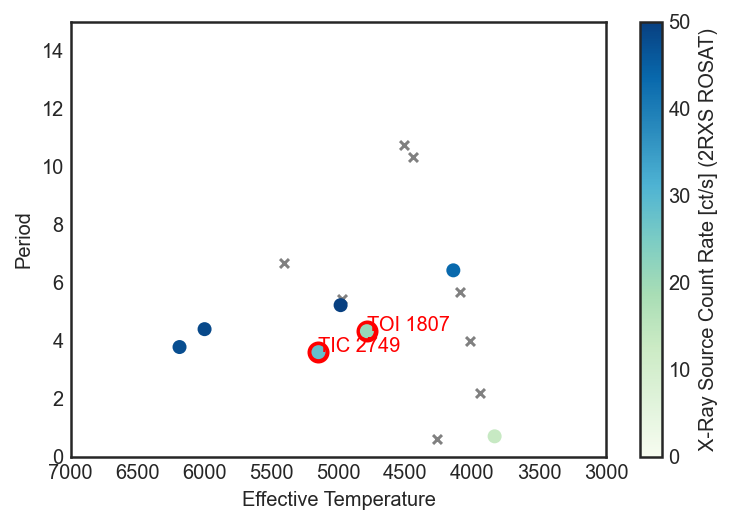

In [103]:
fig = plt.figure()
#plt.scatter(pl2['B'] - pl2['R'], pl2.period, c='k', s=5)
plt.scatter(df.teff_val, df.period, c=df.xraycounts, cmap='GnBu', vmin=0, vmax=50)
cbar = plt.colorbar()
cbar.set_label('X-Ray Source Count Rate [ct/s] (2RXS ROSAT)')
k = ~np.isfinite(df.xraycounts)
plt.scatter(df.teff_val[k], df.period[k], c='grey', vmin=0, vmax=50, s=20, zorder=-10, marker='x')

plt.scatter(df.teff_val[og], df.period[og], c='r', s=100, zorder=-1)
plt.scatter(df.teff_val[twin], df.period[twin], c='r', s=100, zorder=-1)

plt.text(df.teff_val[og], df.period[og], 'TIC 2749', color='r')
plt.text(df.teff_val[twin], df.period[twin], 'TOI 1807', color='r')


#plt.scatter(df.loc[0].teff_val, df.loc[0].period/2, marker='x', c='grey')
plt.xlim(7000, 3000)
plt.ylim(0, 15)
plt.xlabel('Effective Temperature')
plt.ylabel('Period')
fig.savefig('xray-counts.png', dpi=200)